In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bemcs
import warnings

warnings.filterwarnings("ignore")

[100. 100. 100. 100. 100. 100. 100. 100.   1.   1.   1.]


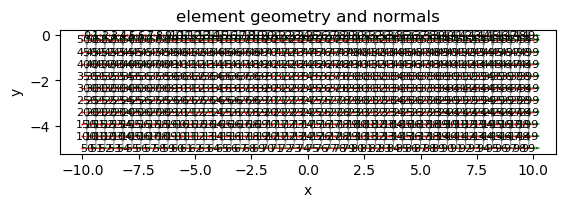

In [2]:
# Elastic parameter (shear modulus)
mu = 1.0
Lscale = 10
npts_layer = 51

els_source = bemcs.initialize_els()
els_topo = bemcs.initialize_els()
els_b = bemcs.initialize_els()
els = bemcs.initialize_els()

# setup a fault geometry (source)
els_source.x1 = np.array([-0.0])
els_source.y1 = np.array([-0.5])
els_source.x2 = np.array([0.0])
els_source.y2 = np.array([-1e5])
bemcs.standardize_els_geometry(els_source, reorder=False)

# topography
xvals = np.linspace(-Lscale, Lscale, npts_layer)
els_topo.x1 = xvals[0:-1]
els_topo.x2 = xvals[1:]
els_topo.y1 = np.zeros_like(els_topo.x1)
els_topo.y2 = np.zeros_like(els_topo.x1)
bemcs.standardize_els_geometry(els_topo, reorder=False)

# layered structure
nlayers = 10
zlayer = np.linspace(-5, -0.2, nlayers)
mulayer = np.linspace(10, 1, nlayers + 1)
mulayer[0:8] = 100.0
mulayer[8::] = 1.0
print(mulayer)

# mulayer = 5.0 * np.ones_like(mulayer)

x1 = []
x2 = []
y1 = []
y2 = []

# calculation the dμ/dx and dμ/dy terms as α,β
beta = np.ones(len(zlayer) * (npts_layer - 1))
for i in range(len(zlayer)):
    xvals = np.linspace(-Lscale, Lscale, npts_layer)
    x1 = np.hstack([x1, xvals[0:-1]])
    x2 = np.hstack([x2, xvals[1:]])
    y1 = np.hstack([y1, np.ones(npts_layer - 1) * zlayer[i]])
    y2 = np.hstack([y2, np.ones(npts_layer - 1) * zlayer[i]])
    beta[i * (npts_layer - 1) : (npts_layer - 1) * (i + 1)] = (
        -(mulayer[i + 1] - mulayer[i]) / mulayer[i + 1]
    )

els_b.x1 = x1
els_b.x2 = x2
els_b.y1 = y1
els_b.y2 = y2
bemcs.standardize_els_geometry(els_b, reorder=False)

# combine topo and layered structure
els.x1 = np.hstack([els_topo.x1, els_b.x1])
els.x2 = np.hstack([els_topo.x2, els_b.x2])
els.y1 = np.hstack([els_topo.y1, els_b.y1])
els.y2 = np.hstack([els_topo.y2, els_b.y2])

# label topo index
topoindex = np.hstack(
    [np.ones(len(els_topo.x1), dtype=bool), np.zeros(len(els_b.x1), dtype=bool)]
)

bemcs.standardize_els_geometry(els, reorder=False)
n_els = len(els.x1)

bemcs.plot_els_geometry(els)

In [3]:
dr = -1e-6
xo = els.x_centers + dr * els.x_normals
yo = els.y_centers + dr * els.y_normals
K_sx, K_sy, _ = bemcs.get_displacement_stress_kernel_slip_antiplane(
    xo, yo, els_source, mu
)
quadcoefs = np.ones(3)

# compute strain due to source at els
ex0 = K_sx @ quadcoefs
ey0 = K_sy @ quadcoefs

# print(2 * ex0[topoindex].reshape(-1, 1))

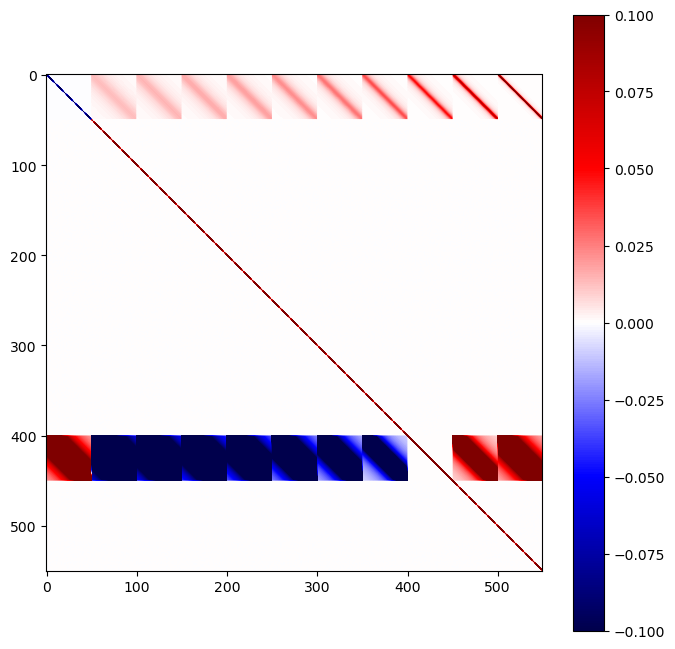

In [4]:
# compute els force kernels
K_sx, K_sy, _ = bemcs.get_displacement_stress_kernel_force_antiplane(xo, yo, els, mu)
# construct constant kernels from linear kernels for this simple example
K_x = np.zeros((n_els, n_els))
K_y = np.zeros((n_els, n_els))
for i in range(n_els):
    K_x[:, i] = K_sx[:, 2 * i] + K_sx[:, 2 * i + 1]
    K_y[:, i] = K_sy[:, 2 * i] + K_sy[:, 2 * i + 1]

kernel = np.vstack(
    [
        np.hstack([K_y[topoindex][:, topoindex], K_y[topoindex][:, ~topoindex]]),
        np.hstack(
            [
                -np.repeat(beta.reshape(-1, 1), len(els_topo.x1), axis=1)
                * K_y[~topoindex][:, topoindex],
                np.eye(len(els_b.x1))
                - np.repeat(beta.reshape(-1, 1), len(els_b.x1), axis=1)
                * K_y[~topoindex][:, ~topoindex],
            ]
        ),
    ]
)
plt.figure(figsize=(8, 8))
plt.imshow(kernel, cmap="seismic")
plt.colorbar()
plt.clim([-0.1, 0.1])
plt.show()

# solve system to get body forces (WEIRD negative sign issue with slip kernels)
rhsvec = np.vstack(
    [-ey0[topoindex].reshape(-1, 1), (beta * ey0[~topoindex]).reshape(-1, 1)]
)
# print(np.linalg.cond(kernel))
solvec = np.linalg.pinv(kernel) @ rhsvec

# solve for purely topographic contribution
# toposolvec = np.linalg.pinv(K_y[topoindex][:, topoindex]) @ (
#     -ey0[topoindex].reshape(-1, 1)
# )

# plt.figure()
# plt.plot(els_topo.x_centers, solvec[topoindex], "o-")
# plt.plot(els.x_centers[~topoindex], solvec[~topoindex], "k.")
# plt.xlim([-5, 5])
# plt.show()

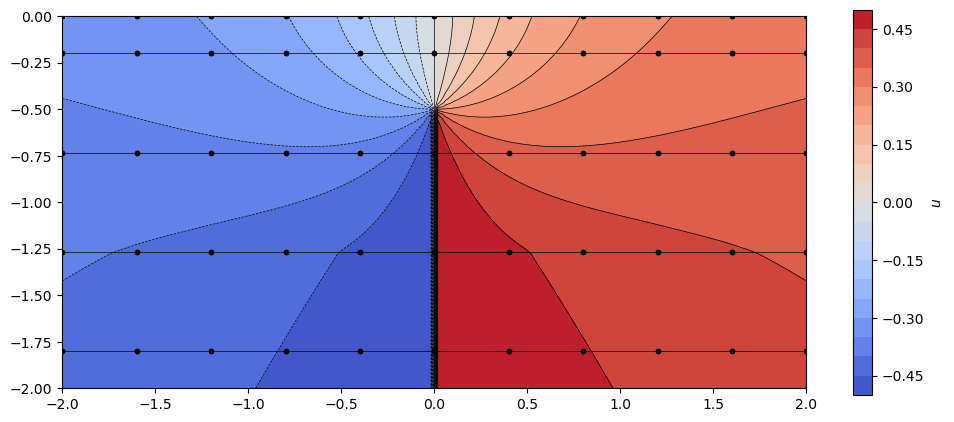

In [5]:
# plot resulting displacement field
nx_obs = 100
ny_obs = 100
x_obs = np.linspace(-2, 2, nx_obs)
y_obs = np.linspace(-2, 0, ny_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
xo = x_obs.flatten().reshape(-1, 1)
yo = y_obs.flatten().reshape(-1, 1)

_, _, K_u = bemcs.get_displacement_stress_kernel_force_antiplane(xo, yo, els, mu)
Ku = np.zeros((len(xo), n_els))
for i in range(n_els):
    Ku[:, i] = K_u[:, 2 * i] + K_u[:, 2 * i + 1]
_, _, Ku0 = bemcs.get_displacement_stress_kernel_slip_antiplane(xo, yo, els_source, mu)
# compute displacements
u = Ku @ solvec + Ku0 @ quadcoefs.reshape(-1, 1)

plt.figure(figsize=(12, 5))
toplot = u.reshape(ny_obs, nx_obs)
maxval = 0.5
minval = -maxval
levels = np.linspace(minval, maxval, 21)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-", linewidth=0.5)
plt.colorbar(label="$u$")
plt.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
plt.xlim([-2, 2])
plt.ylim([-2, 0])
plt.gca().set_aspect("equal", adjustable="box")

In [6]:
mulayer

array([100., 100., 100., 100., 100., 100., 100., 100.,   1.,   1.,   1.])